<a href="https://colab.research.google.com/github/sambitdash/EVA-2/blob/master/Session-6/Assignment-6A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment - 6B

## Importing Libraries and Symbols

In [1]:
from tensorflow.keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
np.random.seed(2017) 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, MaxPooling2D, AveragePooling2D, SeparableConv2D
from tensorflow.keras.layers import Activation, Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, Input, concatenate, add
from tensorflow.keras import utils as np_utils

## Load the Dataset
CIFAR-10 dataset is loaded. It's  32×32  images with 50,000 images in the trainset and 10,000 in the test set.

In [2]:
from tensorflow.keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

## Show the Data
One sample data is shown from each class to get and understanding of the underlying data visually.

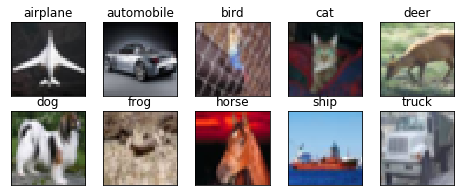

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

## Image Normalization

The images are normalized for the complete training set. Thus, the mean and standard deviation of the training set is assumed to be the true mean and standard deviations. 

In [4]:
#train_features /= 255
#train_features /= 255


X_mean = np.mean(train_features, axis=0, keepdims=True)
X_std  = np.std(train_features, axis=0, keepdims=True)
X_std  = np.clip(X_std, 1.0/255, 1.0)


train_features = train_features - X_mean
test_features  = test_features  - X_mean

train_features = np.divide(train_features, X_std)
test_features  = np.divide(test_features, X_std)

## Utility Methods

Two utility methods are generated:

1. Plot the model history of the loss and accuracy
2. Compute the final accuracy at the end of the runs

In [5]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['categorical_accuracy'])+1),model_history.history['categorical_accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_categorical_accuracy'])+1),model_history.history['val_categorical_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['categorical_accuracy'])+1),len(model_history.history['categorical_accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [6]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

## Convert output to one hot vector format

In [7]:
# train_features = train_features.astype('float32')/255
# test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_ohv = np_utils.to_categorical(train_labels, num_classes)
test_ohv  = np_utils.to_categorical(test_labels, num_classes)

print(test_ohv.shape)

(10000, 10)


## Model

The model has following characteristics.

1. Functional Model
2. Data converted to space to depth to accomodate change in size of images for skip connections.
3. Most concatenation operations are followed with 1x1 convolutions to reduce channel depth.
4. Tensorflow space to depth API used to reduce size of images.

In [8]:
# Define the model

from tensorflow.nn import space_to_depth

def norm(x):
    return Activation('relu')(BatchNormalization()(x))

x01 = Input(shape=(32, 32, 3))
x02 = norm(SeparableConv2D(32, (5, 5), padding='same')(x01))
x03 = norm(Conv2D(32, (5, 5),          padding='same')(x02))
x04 = norm(Conv2D(32, (5, 5),          padding='same')(x03))
x05 = norm(SeparableConv2D(32, (5, 5), padding='same')(concatenate([x02, x04])))
x06 = MaxPooling2D()(Conv2D(32, (1,1))(concatenate([x02, x05])))

x021 = space_to_depth(x02, 2)
x041 = space_to_depth(x04, 2)
x051 = space_to_depth(x05, 2)

x07 = norm(SeparableConv2D(32, (3, 3), padding='same')(x06))
x08 = norm(Conv2D(16, (5, 5),          padding='same')(Conv2D(32, (1,1))(concatenate([x021, x051, x07]))))
x09 = norm(SeparableConv2D(32, (3, 3), padding='same')(Conv2D(32, (1,1))(concatenate([x041, x051, x07, x08]))))
x10 = norm(SeparableConv2D(32, (5, 5), padding='same')(Conv2D(32, (1,1))(concatenate([x021, x041, x051, x07, x08, x09]))))
x11 = MaxPooling2D()(Conv2D(32, (1,1))(concatenate([x021, x051, x07, x09, x10])))

x022 = space_to_depth(x02, 4)
x032 = space_to_depth(x03, 4)
x042 = space_to_depth(x04, 4)
x052 = space_to_depth(x05, 4)
x071 = space_to_depth(x07, 2)
x081 = space_to_depth(x08, 2)
x091 = space_to_depth(x09, 2)

x12 = norm(Conv2D(32, (5, 5),          padding='same')(Conv2D(32, (1,1))(concatenate([x081, x11]))))
x13 = norm(SeparableConv2D(32, (5, 5), padding='same')(Conv2D(32, (1,1))(concatenate([x032, x052, x12]))))
x14 = norm(Conv2D(32, (3, 3),          padding='same')(Conv2D(32, (1,1))(concatenate([x032, x042, x071, x12, x13]))))
x15 = norm(SeparableConv2D(32, (5, 5), padding='same')(Conv2D(32, (1,1))(concatenate([x022, x042, x052, x071, x091, x13, x14]))))

x16 = norm(Conv2D(10, (1, 1), activation='relu')(concatenate([x052, x091, x13, x15])))
x16 = AveragePooling2D((8, 8))(x16)
x16 = Activation('softmax')(x16)
x16 = Flatten()(x16)

model = Model(inputs=x01, outputs=x16)

from tensorflow.keras.optimizers import Adam
# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='poisson', metrics=['categorical_accuracy'])


W0905 07:18:22.653626 139647026702144 deprecation.py:506] From /home/sambit/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
separable_conv2d (SeparableConv (None, 32, 32, 32)   203         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 32)   128         separable_conv2d[0][0]           
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

## Training

Random eraser, image affine transformations are used as regularizers. Dropout was not used as random eraser has similar effect. 

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import LearningRateScheduler

(init_epoch, nepoch) = (0, 100)

def scheduler(epoch, lr):
  return 0.001 * 1/(1 + epoch)

import numpy as np

def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser


datagen = ImageDataGenerator(
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False ,  # randomly flip images
        preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=True)
)


# train the model
start = time.time()

model_info = model.fit_generator(datagen.flow(train_features, train_ohv, batch_size = 128),
                                 epochs = nepoch, 
                                 validation_data = (test_features, test_ohv), verbose=1, 
                                 callbacks=[LearningRateScheduler(scheduler)])
end = time.time()

Epoch 1/100
391/391 [==============================] - 31s 80ms/step - loss: 0.2732 - categorical_accuracy: 0.4127 - val_loss: 0.2672 - val_categorical_accuracy: 0.4354
Epoch 2/100
391/391 [==============================] - 26s 67ms/step - loss: 0.2386 - categorical_accuracy: 0.5377 - val_loss: 0.2344 - val_categorical_accuracy: 0.5462
Epoch 3/100
391/391 [==============================] - 26s 67ms/step - loss: 0.2247 - categorical_accuracy: 0.5864 - val_loss: 0.2144 - val_categorical_accuracy: 0.6166
Epoch 4/100
391/391 [==============================] - 26s 67ms/step - loss: 0.2164 - categorical_accuracy: 0.6138 - val_loss: 0.2121 - val_categorical_accuracy: 0.6255
Epoch 5/100
391/391 [==============================] - 26s 67ms/step - loss: 0.2113 - categorical_accuracy: 0.6317 - val_loss: 0.2383 - val_categorical_accuracy: 0.5577
Epoch 6/100
391/391 [==============================] - 26s 67ms/step - loss: 0.2069 - categorical_accuracy: 0.6466 - val_loss: 0.2041 - val_categorical_acc

391/391 [==============================] - 26s 67ms/step - loss: 0.1760 - categorical_accuracy: 0.7465 - val_loss: 0.1710 - val_categorical_accuracy: 0.7668
Epoch 98/100
391/391 [==============================] - 26s 67ms/step - loss: 0.1762 - categorical_accuracy: 0.7471 - val_loss: 0.1723 - val_categorical_accuracy: 0.7655
Epoch 99/100
391/391 [==============================] - 26s 67ms/step - loss: 0.1754 - categorical_accuracy: 0.7470 - val_loss: 0.1726 - val_categorical_accuracy: 0.7643
Epoch 100/100
391/391 [==============================] - 26s 67ms/step - loss: 0.1758 - categorical_accuracy: 0.7471 - val_loss: 0.1732 - val_categorical_accuracy: 0.7596


## Results

Model took 2628.86 seconds to train


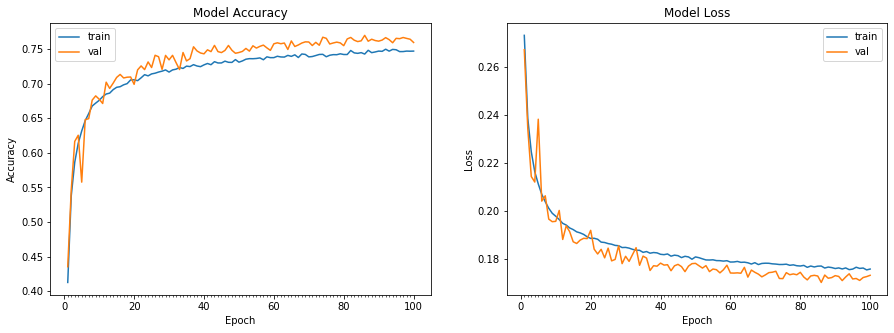

Accuracy on test data is: 75.96


In [11]:
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_ohv, model))